Notebook purpose

- Perform entire analysis

In [68]:
import contextlib
import os
import re
import sys

import linearmodels as lm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.data.selectors as sl
import entropy.figures.figures as ff
import entropy.figures.helpers as fh
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh
from entropy import config

sns.set_style("whitegrid")
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
df = hd.read_analysis_data()
hd.inspect(df)

Time for read_analysis_data: 0.40 seconds
(1,818, 26)


obs    balance_ca  balance_sa  sa_inflows  sa_outflows  \
user_id date                                                                 
7777    2012-11-30   59  14688.584961         0.0         NaN       3000.0   
        2012-12-31   87   8629.639648         0.0  947.799988        600.0   

                    sa_net_inflows  sa_scaled_inflows  sa_scaled_outflows  \
user_id date                                                                
7777    2012-11-30             NaN           4.847612            1.328380   
        2012-12-31      347.799988           0.419679            0.265676   

                    sa_scaled_net_inflows  total_monthly_spend  \
user_id date                                                     
7777    2012-11-30                    NaN                  NaN   
        2012-12-31               0.154004             8.270668   

                    tag_spend_finance  tag_spend_motor  tag_spend_household  \
user_id date                                                                  
7777    2012-11-30                NaN         0.147929             0.146385   
        2012-12-31            0.46155         0.158494             0.090986   

                    tag_spend_retail  tag_spend_other_spend  \
user_id date                                                  
7777    2012-11-30          0.043189               0.434601   
        2012-12-31          0.046303                    NaN   

                    tag_spend_services  tag_spend_communication  \
user_id date                                                      
7777    2012-11-30            0.207271                 0.020625   
        2012-12-31            0.164630                 0.073868   

                    tag_spend_travel  tag_spend_hobbies        income  \
user_id date                                                            
7777    2012-11-30           0.00000                0.0  27100.681641   
        2012-12-31           0.00417                0.0  27100.681641   

                    log_income  user_female   age      region  txn_count_ca  \
user_id date                                                                  
7777    2012-11-30   10.207314          0.0  29.0  South East          51.0   
        2012-12-31   10.207314          0.0  29.0  South East          82.0   

                    txn_count_sa  
user_id date                      
7777    2012-11-30           8.0  
        2012-12-31           5.0

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1818 entries, (7777, Timestamp('2012-11-30 00:00:00')) to (582777, Timestamp('2018-12-31 00:00:00'))
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   obs                      1818 non-null   int64  
 1   balance_ca               1768 non-null   float32
 2   balance_sa               638 non-null    float32
 3   sa_inflows               613 non-null    float32
 4   sa_outflows              613 non-null    float32
 5   sa_net_inflows           606 non-null    float32
 6   sa_scaled_inflows        613 non-null    float64
 7   sa_scaled_outflows       613 non-null    float64
 8   sa_scaled_net_inflows    606 non-null    float64
 9   total_monthly_spend      1764 non-null   float32
 10  tag_spend_finance        1780 non-null   float32
 11  tag_spend_motor          1799 non-null   float32
 12  tag_spend_household      1780 non-null   float32
 13  t

In [112]:
df.obs.to_frame().columns

Index(['obs'], dtype='object')

In [ ]:
def full_controls_subsample(df):
    """Restricts sample to"""

## Sample description

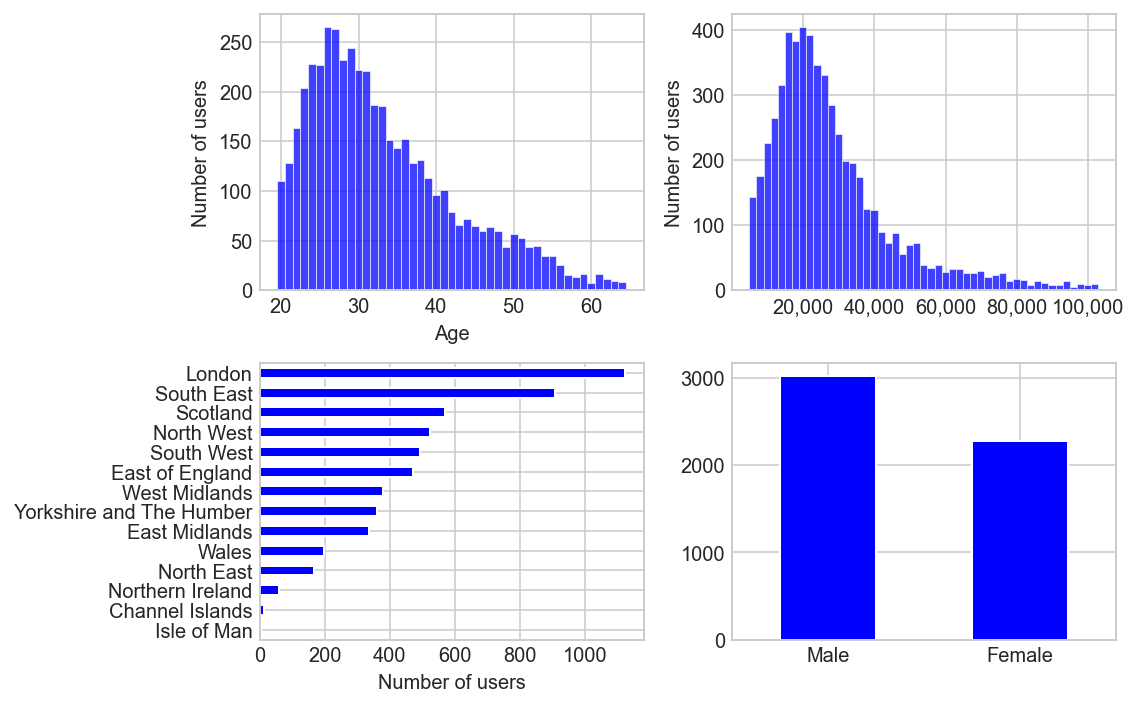

In [ ]:
ff.sample_description(df, write=False)

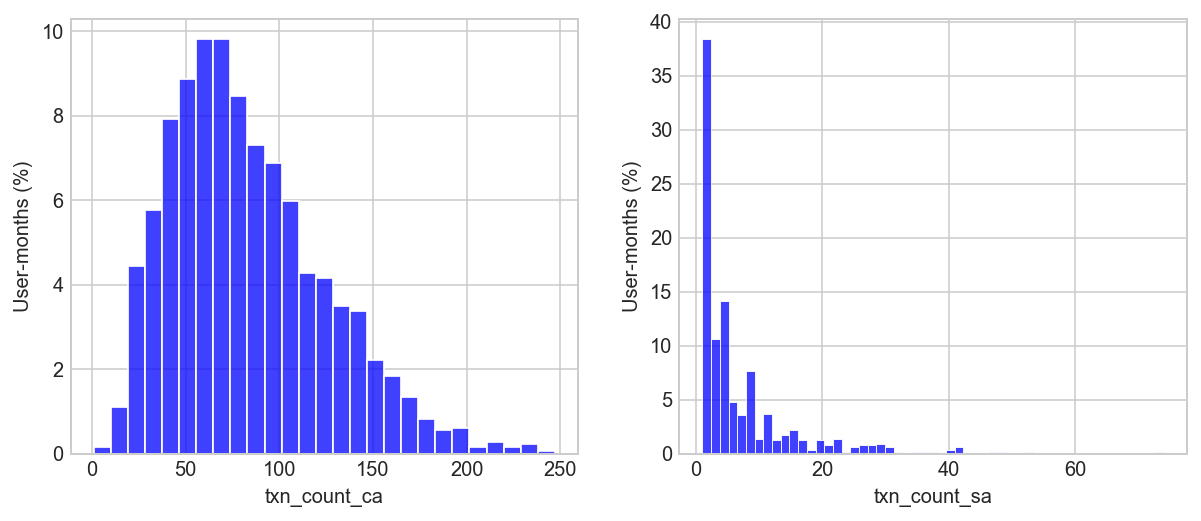

In [121]:
def txns_counts(df, write=True):
    """Plots distribution of txns per user-month for current and savings accounts."""
    colour = "blue"
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for idx, var in enumerate(["txn_count_ca", "txn_count_sa"]):
        sns.histplot(data=df[var], color=colour, stat="percent", ax=ax[idx])
        fh.set_axis_labels(ax[idx], var, "User-months (%)")
    return fig


fig = txns_counts(df)

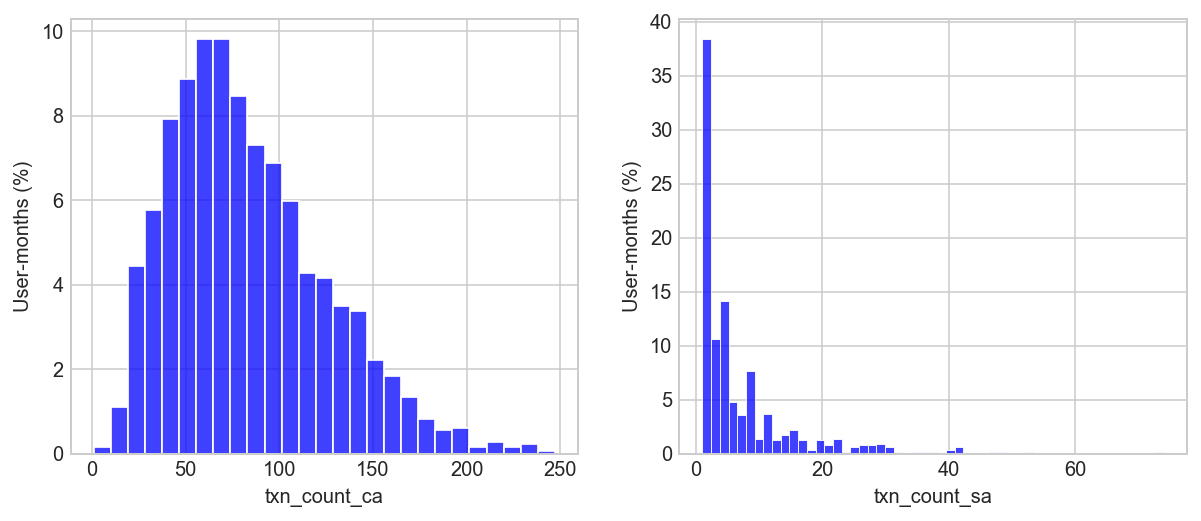

In [122]:
fig

In [120]:
df.txn_count_ca.describe()

count    1806.000000
mean       83.316722
std        41.312248
min         1.000000
25%        52.250000
50%        76.000000
75%       108.000000
max       247.000000
Name: txn_count_ca, dtype: float64

In [ ]:
def num_txns_by_account_type(df, write=True):
    """Plots boxenplot with number of monthly transactions by account type."""

    def make_data(df):
        mask = df.account_type.isin(["current", "credit card", "savings"])
        return (
            df.loc[mask]
            .set_index("date")
            .groupby(["account_type", "account_id"], observed=True)
            .resample("M")
            .id.count()
            .rename("num_txns")
            .reset_index()
        )

    def make_figure(df):
        fig, ax = plt.subplots()
        order = ["current", "credit card", "savings"]
        ax = sns.boxenplot(data=df, x="num_txns", y="account_type", order=order)
        return fig, ax

    def set_ytick_labels(ax):
        # capitalise first letter of, and add 'account' suffix to, ytick labels
        to_label = lambda x: " ".join([x[0].upper() + x[1:], "accounts"])
        ytick_labels = [to_label(i.get_text()) for i in ax.get_yticklabels()]
        ax.set_yticklabels(ytick_labels)

    fig, ax = make_figure(make_data(df))
    set_ytick_labels(ax)
    fh.set_axis_labels(ax, xlabel="Number of transactions per month", ylabel="")
    fh.set_size(fig)
    if write:
        fh.save_fig(fig, "num_txns_by_account_type.png")

In [78]:
try:
    ff.num_txns_by_account_type(df, write=False)
except AttributeError:
    pass

## Summary statistics

In [49]:
import entropy.analysis.sumstats_table as eas

eas.main(df, write=False)

,count,mean,std,min,max,25%,50%,75%
obs,163915.0,98.068859,51.257414,11.000000,656.000000,63.000000,89.000000,123.000000
balance_ca,159116.0,1130.199463,4834.210938,-12257.117188,34628.589844,-884.007996,81.886841,1395.455078
balance_sa,64935.0,2625.156006,5496.725586,-1644.621460,42168.609375,2.210007,457.499939,2500.000000
sa_inflows,60583.0,780.843750,1507.547729,0.000000,13800.000000,60.000000,251.000000,790.385010
sa_outflows,60583.0,749.975220,1452.101318,0.000000,12075.480469,0.000000,200.000000,800.000000
sa_net_inflows,61195.0,75.746101,3330.151123,-69750.000000,120000.000000,-180.000000,17.700001,256.000000
sa_scaled_inflows,59977.0,0.335841,0.548266,0.000000,4.137818,0.031901,0.134704,0.383184
sa_scaled_outflows,59977.0,0.332819,0.576240,0.000000,4.039455,0.000000,0.105145,0.392159
sa_scaled_net_inflows,59971.0,0.007137,0.614697,-4.034811,4.184336,-0.084530,0.008627,0.133873
total_monthly_spend,156510.0,7.281420,0.728324,4.954418,9.161083,6.816706,7.300010,7.781670


## Dependent variable - savings

## Independent variable - entropy

## Correlations

In [152]:
data["entropy_pct"] = data.entropy_sptac.rank(pct=True)

In [70]:
def make_data(df, col_name, **trim_kws):
    return (
        df.set_index("entropy_sptac", append=True)
        .loc[:, col_name]
        .rename("value")
        .reset_index("entropy_sptac")
    )


def make_plot(df, axis):
    sns.regplot(
        data=df,
        y="value",
        x="entropy_sptac",
        lowess=True,
        x_bins=20,
        x_ci=None,
        ci=95,
        ax=ax[axis],
    )

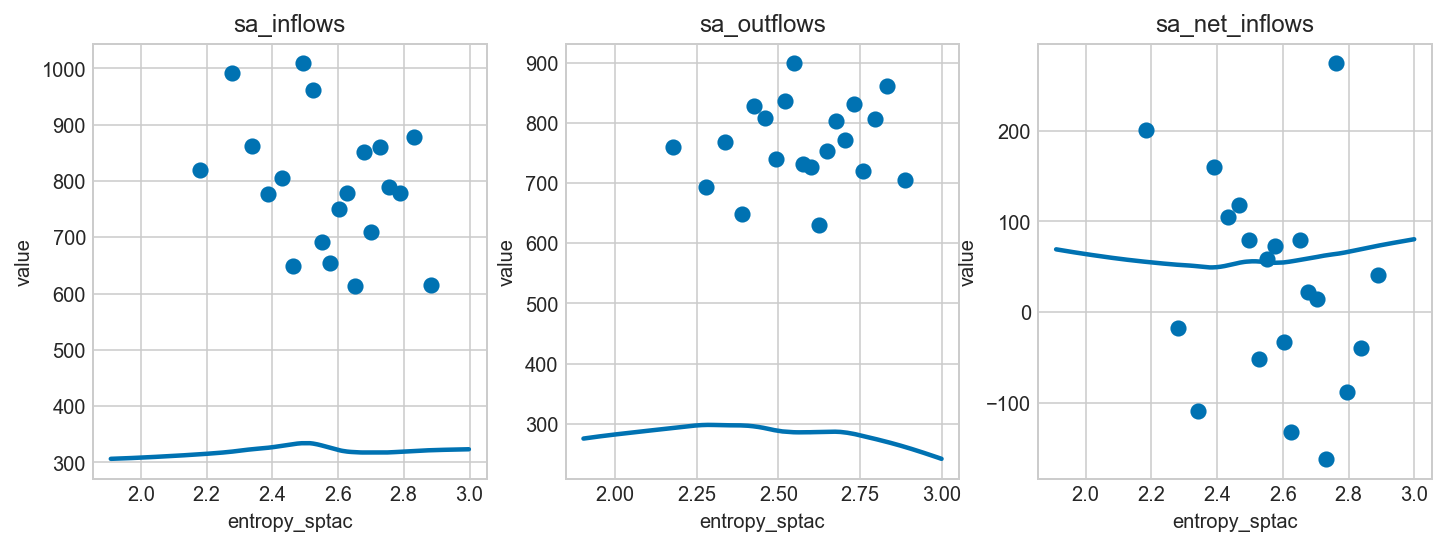

In [74]:
pattern = "sa_[oin]"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var).sample(frac=0.1)
    make_plot(d, idx)
    ax[idx].set_title(var)

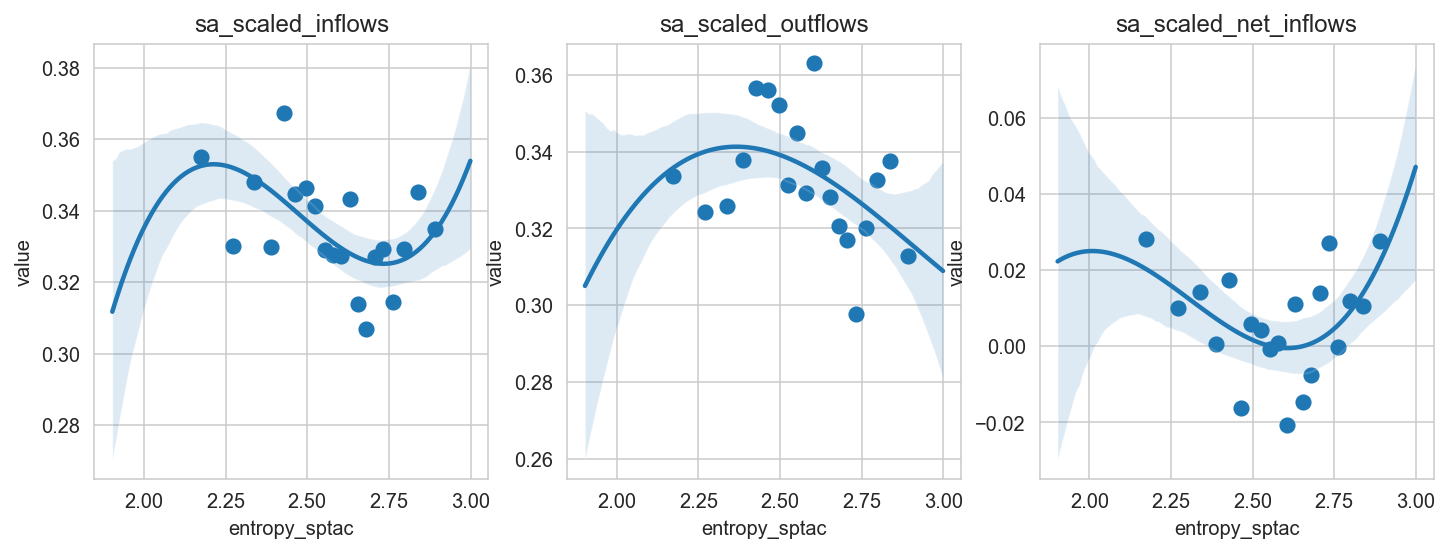

In [45]:
pattern = "sa_scaled"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var).sample(frac=0.1)
    make_plot(d, idx)
    ax[idx].set_title(var)

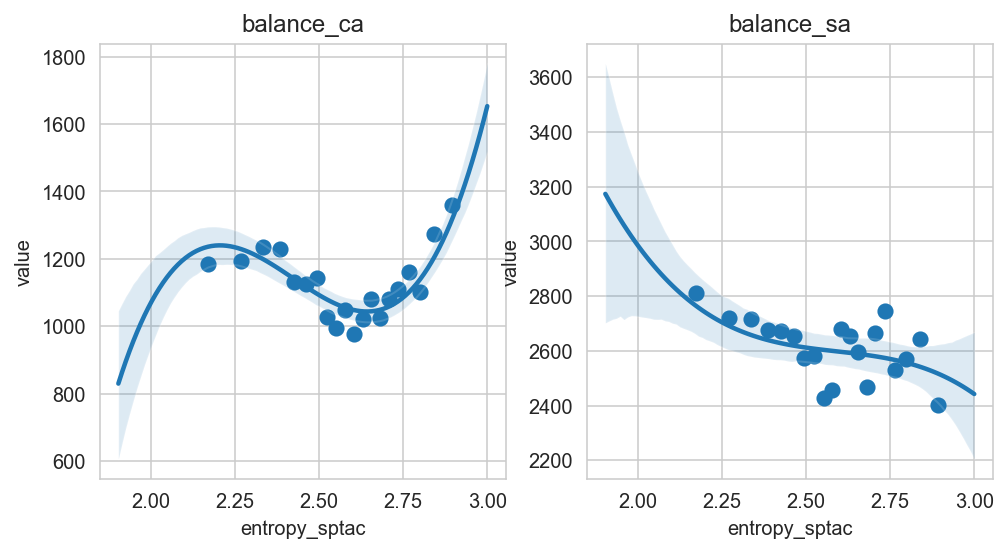

In [42]:
pattern = "balance_"
outcome_vars = hd.colname_subset(data, pattern)
num_vars = len(outcome_vars)
fig, ax = plt.subplots(1, num_vars, figsize=(4 * num_vars, 4))
for idx, var in enumerate(outcome_vars):
    d = make_data(data, col_name=var)
    make_plot(d, idx)
    ax[idx].set_title(var)

## Results

### Fixed effects

In [76]:
data = df
y = data["sa_inflows"]
tag_spend = hd.colname_subset(data, "tag_spend")[:-1]
full_controls = ["log_income", "total_monthly_spend"] + tag_spend[:-1]


b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "total_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_valu

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,59495,59495,56959,55512,54690,54690,54690,54690,54690
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,6.465e-05,0.0013,0.0012,0.0006,0.0036,0.0036,0.0039,0.0302,0.2274
R-Squared (Within),8.723e-05,0.0015,0.0013,0.0006,0.0039,0.0039,0.0039,0.0009,-0.0005
R-Squared (Between),-0.2207,-0.6461,0.3969,-0.0890,-2.6600,-2.6600,-2.8361,-9.9136,0.4288
R-Squared (Overall),-0.1085,-0.2563,0.2046,-0.0444,-1.2523,-1.2523,-1.3377,-4.7859,0.2274
F-statistic,3.6040,37.283,30.798,3.8078,18.451,18.451,19.975,169.74,1609.3
P-value (F-stat),0.0576,0.0000,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000


In [75]:
data = df
y = data["sa_scaled_inflows"]
tag_spend = hd.colname_subset(data, "tag_spend")[:-1]
full_controls = ["log_income", "total_monthly_spend"] + tag_spend[:-1]


b = lm.PanelOLS(
    y,
    data["entropy_sptac"],
    entity_effects=True,
    time_effects=True,
).fit()
ba = lm.PanelOLS(
    y,
    data[["entropy_sptac", "log_income"]],
    entity_effects=True,
    time_effects=True,
).fit()
bd = lm.PanelOLS(
    y,
    data[["entropy_sptac", "total_monthly_spend"]],
    entity_effects=True,
    time_effects=True,
).fit()
be = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + tag_spend[:-1]],
    entity_effects=True,
    time_effects=True,
).fit()
bf = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit()
bg = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bh = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=True,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)
bi = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=True,
).fit(cov_type="clustered", cluster_entity=True)
bj = lm.PanelOLS(
    y,
    data[["entropy_sptac"] + full_controls],
    entity_effects=False,
    time_effects=False,
).fit(cov_type="clustered", cluster_entity=True)


lm.panel.compare([b, ba, bd, be, bf, bg, bh, bi, bj], stars=True)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/linearmodels/shared/exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_valu

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8
Dep. Variable,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows,sa_scaled_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,58895,58895,56459,54998,54217,54217,54217,54217,54217
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered,Clustered,Clustered,Clustered
R-squared,6.163e-05,0.0096,0.0009,0.0007,0.0130,0.0130,0.0132,0.0246,0.2837
R-Squared (Within),5.309e-05,0.0096,0.0009,0.0007,0.0132,0.0132,0.0132,0.0095,0.0019
R-Squared (Between),-0.2101,-29.110,0.3589,-0.2600,-23.595,-23.595,-22.780,-6.3878,0.4976
R-Squared (Overall),-0.1119,-15.039,0.1983,-0.1411,-12.538,-12.538,-12.107,-3.4196,0.2837
F-statistic,3.3990,266.60,23.709,4.4216,66.483,66.483,67.647,136.50,2147.3
P-value (F-stat),0.0652,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


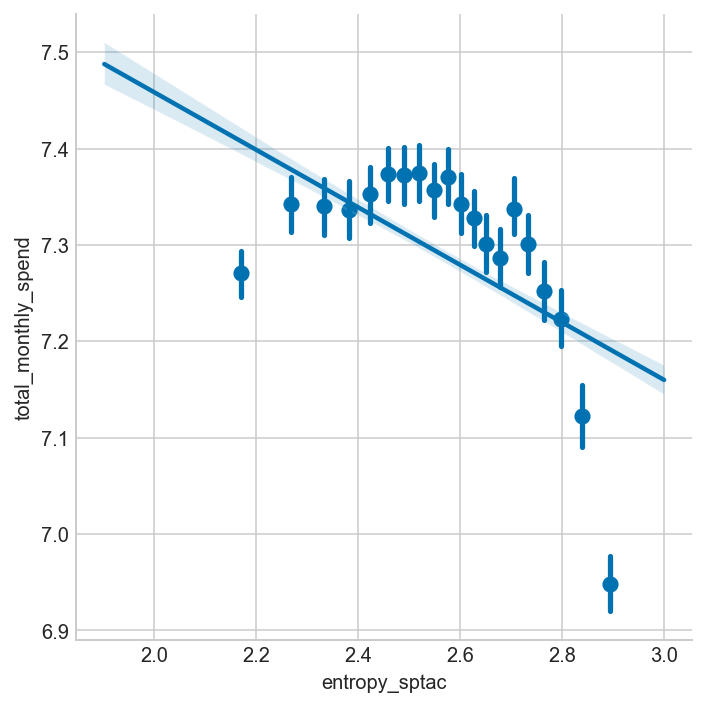

In [67]:
sns.lmplot(
    data=df.sample(frac=0.3), x="entropy_sptac", y="total_monthly_spend", x_bins=20
)

### Pooled regressions

In [58]:
full_controls = ["log_income", "age", "user_female", "total_monthly_spend"] + tag_spend

a = lm.PanelOLS(y, sm.add_constant(data["entropy_sptac"])).fit()
aa = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "log_income"]])).fit()
ab = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "age"]])).fit()
ac = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac", "user_female"]])).fit()
ad = lm.PanelOLS(
    y, sm.add_constant(data[["entropy_sptac", "total_monthly_spend"]])
).fit()
ae = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + tag_spend[:-1]])).fit()
af = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit()
ag = lm.PanelOLS(y, sm.add_constant(data[["entropy_sptac"] + full_controls])).fit(
    cov_type="clustered", cluster_entity=True
)


lm.panel.compare([a, aa, ab, ac, ad, ae, af, ag], stars=True)

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7
Dep. Variable,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows,sa_inflows
Estimator,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS,PanelOLS
No. Observations,59495,59495,53783,56609,56959,55512,46825,46825
Cov. Est.,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Unadjusted,Clustered
R-squared,7.581e-05,0.0181,0.0039,0.0036,0.0172,0.0056,0.0329,0.0329
R-Squared (Within),8.388e-05,0.0009,0.0001,6.38e-05,-0.0025,-0.0029,0.0011,0.0011
R-Squared (Between),-0.0018,0.0397,0.0066,0.0075,0.0428,0.0165,0.0783,0.0783
R-Squared (Overall),7.581e-05,0.0181,0.0039,0.0036,0.0172,0.0056,0.0329,0.0329
F-statistic,4.5104,549.70,104.89,101.66,499.84,39.325,122.39,122.39
P-value (F-stat),0.0337,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
